### **Proyecto Detección de Anomalías**

Proyecto #3 de la materia Ingeniería de Caracteristicas impartida por el Dr. Julio Waissman en la Maestría en Ciencia de Datos.

Elaborado por:

*   Ana Paola Velez Esquer
*   Daniel Mendoza Camacho
*   Carlos Alejandro Velázquez Valdez

Los datos utilizados en este proyecto fueron extraídos de la base de datos del proyecto [Pronostico Meteorologico de la Universidad de Sonora](https://meteodatos.unison.mx/) (PROMETEUS). Los registros pertenecen a datos de pronósticos meteorológicos (precipitación, temperatura, humedad, etc.) tomados de diversos municipios de Sonora y Chihuahua de 03/Julio/2021 al 06/Julio/2021



### **Planteamiento del Problema**


El Dataset de PROMETEUS tiene registros de datos meteorológicos de diferentes ciudades, con estos datos podemos obtener *insights* interesantes, resolviendo preguntas como: ¿Cómo varían las caracteristicas con respecto a cada ciudad?(por ejemplo ¿Qué ciudades presentaron mayores y menores temperaturas durante este periodo?. Tambien es importante saber como están relacionadas las variables unas con otras, para tener una idea del comportamiento de los datos, esto se logrará con el analisis exploratorio de datos. 

Sin embargo, si nosotros quisieramos usar algoritmos de Machine Learning para predecir estas variables meteorológicas, primero tendríamos que detectar y remover outliers ya que los algoritmos son sensibles al rango y distribución de los diferentes valores del dataset. Es por eso que en este proyecto aplicaremos 4 diferentes métodologías de detección de anomalías:    


*   Z-Score
*   Envolvente Elíptica
*   Isolation Forest
*   Local Outlier Factor




---


A continuación presentamos una breve y sencilla explicación de las variables con las que se trabajarán en el Dataset:


*   Temperatura: Temperatura promediada de diferentes puntos de la ciudad reportada en grados Celcius.
*   Precipitación: Precipitación por hora (agua que llovió en la hora inmediata anterior a la anunciada por el mapa, la cual se presenta en milímetros).
*   Precipitación acumulada: lluvia medida durante el período del pronóstico, en este caso, tres días y medio. 
*   Radiación Solar: Valor de la radiación solar en el centro de cada ciudad o localidad. Las unidades son Watts por metro cuadrado (W/m2).
*   Viento: velocidad del viento para el centro de cada ciudad.
*   Humedad:  variable que indica la cantidad de humedad en el ambiente (dada en porcentaje).
*   Agua precipitable: variable que mide la cantidad de agua en forma de vapor en la columna de atmósfera por unidad de área (en este caso en el centor de cada ciudad).



### **Importando las librerías necesarias**

In [52]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### **Extracción de conjuntos tidy de datos y mostando los primeros y ultimos 5 registros**


In [53]:
df = pd.read_csv('http://acarus.uson.mx/~daniel/mcd/20210703_06z.csv')

In [54]:
print("Dimensiones del Dataset:")
print("-" * 25)
print(f"Registros: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")
print("-" * 25)

Dimensiones del Dataset:
-------------------------
Registros: 1190
Columnas: 11
-------------------------


In [55]:
df.head()

,datetime,ciudad,dominio,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
0,2021-07-02 23:00:00,Hermosillo,d01,31,0.0,0.0,0,60.3,4,230,50
1,2021-07-03 00:00:00,Hermosillo,d01,30,0.0,0.0,0,59.7,6,232,47
2,2021-07-03 01:00:00,Hermosillo,d01,30,0.0,0.0,0,60.0,8,226,47
3,2021-07-03 02:00:00,Hermosillo,d01,30,0.0,0.0,0,58.9,8,187,47
4,2021-07-03 03:00:00,Hermosillo,d01,27,0.5,0.5,0,65.0,4,182,66


In [56]:
df.tail()

,datetime,ciudad,dominio,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
1185,2021-07-06 07:00:00,Mazatlán,d01,27,0.0,12.0,309,59.3,4,113,80
1186,2021-07-06 08:00:00,Mazatlán,d01,29,0.0,12.0,537,59.2,4,141,71
1187,2021-07-06 09:00:00,Mazatlán,d01,30,0.9,12.9,616,61.4,9,188,73
1188,2021-07-06 10:00:00,Mazatlán,d01,31,2.1,15.1,898,61.5,11,202,71
1189,2021-07-06 11:00:00,Mazatlán,d01,31,0.9,16.0,990,60.3,14,212,70


### **Analizando y corrigiendo tipo de datos**

In [57]:
df.dtypes

datetime                    object
ciudad                      object
dominio                     object
temperatura                  int64
precipitacion              float64
precipitacion_acumulada    float64
radiacion_solar              int64
agua_precipitable          float64
vel_viento10m                int64
dir_viento10m                int64
humedad_relativa             int64
dtype: object

In [58]:
df.dominio.unique()

array(['d01'], dtype=object)

Al observar las columnas y sus diferentes tipos de datos, vemos que datetime tiene que pasar de tipo object a datetime y renombrarlo a fecha, ciudad debemos pasarlo de object a datos categoricos. y por ultimo observamos que todos los registros en la columna dominio tienen el mismo dato (d01), por lo que removeremos la columna.

In [59]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.rename(columns={"datetime": "fecha"})
df['ciudad'] = df['ciudad'].astype('category')
df = df.drop(['dominio'], axis = 1)

In [60]:
#Confirmamos que los tipos de datos y nombres de columnas son correctos
df.dtypes

fecha                      datetime64[ns]
ciudad                           category
temperatura                         int64
precipitacion                     float64
precipitacion_acumulada           float64
radiacion_solar                     int64
agua_precipitable                 float64
vel_viento10m                       int64
dir_viento10m                       int64
humedad_relativa                    int64
dtype: object

### **Analizando valores perdidos y duplicados**


In [61]:
df.isnull().sum()

fecha                      0
ciudad                     0
temperatura                0
precipitacion              0
precipitacion_acumulada    0
radiacion_solar            0
agua_precipitable          0
vel_viento10m              0
dir_viento10m              0
humedad_relativa           0
dtype: int64

<AxesSubplot:>

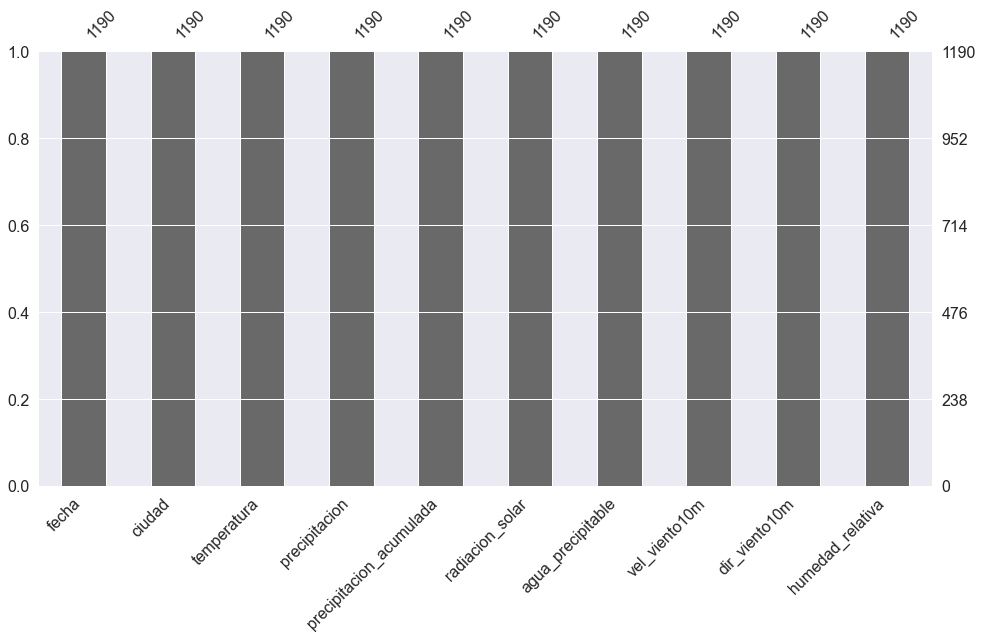

In [62]:
msno.bar(df, figsize=(16,8))

In [63]:
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape
print(f'Numero de registros duplicados: {duplicate_rows_df.shape[0]}')

Numero de registros duplicados: 0


Como podemos notar, el dataframe no tiene valores perdidos ni duplicados, lo cual facilitará su análisis.

### **Análisis Exploratorio de Datos**

Primero observaremos cuantos registros hay para cada ciudad.

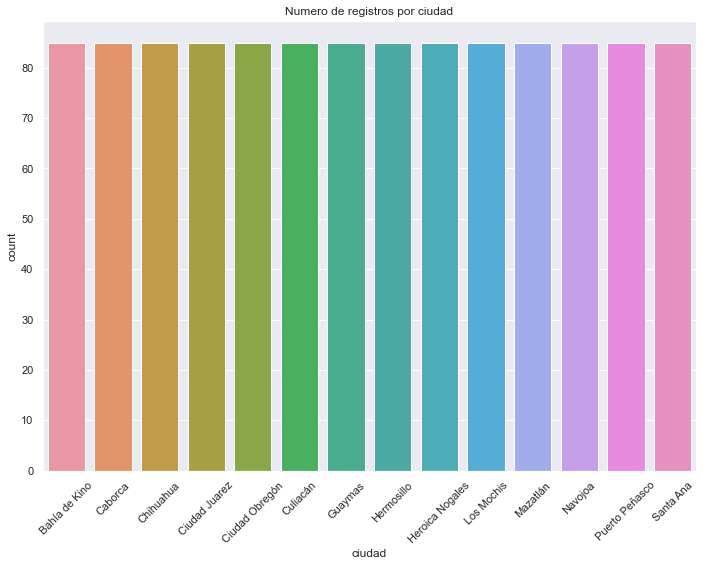

In [64]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data = df, x = 'ciudad')
plt.title('Numero de registros por ciudad')
plt.xticks(rotation = 45)
plt.show()

Despues utilizaremos el método .describe() para ver el comportamiento de los datos.

In [65]:
df.describe()

,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,28.310084,0.329244,17.587983,306.213445,51.303529,9.893277,181.251261,66.747899
std,3.915269,1.635545,22.732623,372.833886,8.998581,5.249971,74.298411,15.943613
min,18.000000,0.000000,0.000000,0.000000,26.700000,0.000000,1.000000,25.000000
25%,26.000000,0.000000,0.800000,0.000000,43.100000,6.000000,135.000000,54.000000
50%,28.000000,0.000000,12.100000,65.000000,53.750000,9.000000,184.000000,68.000000
75%,31.000000,0.000000,23.100000,648.750000,58.500000,13.000000,230.000000,80.000000
max,38.000000,25.000000,99.200000,1079.000000,71.600000,35.000000,359.000000,100.000000


Debido a que el método .describe() nos da estadisiticas importanates de cada columna del DataFrame, a continuación realizaremos un análisis similar para cada ciudad, obteniendo el mínimo, el máximo y el promedio de cada columna para darnos una mejor idea.

In [66]:
df.groupby('ciudad').agg(['mean','min', 'max'])

fecha                                          \
                               mean                 min                 max   
ciudad                                                                        
Bahía de Kino   2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Caborca         2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Chihuahua       2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Ciudad Juarez   2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Ciudad Obregón  2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Culiacán        2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Guaymas         2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Hermosillo      2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Heroica Nogales 2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Los Mochis      2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Mazatlán        2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Navojoa         2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Puerto Peñasco  2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   
Santa Ana       2021-07-04 17:00:00 2021-07-02 23:00:00 2021-07-06 11:00:00   

                temperatura         precipitacion             \
                       mean min max          mean  min   max   
ciudad                                                         
Bahía de Kino     28.517647  26  31      0.000000  0.0   0.0   
Caborca           30.011765  25  36      0.163529  0.0   3.9   
Chihuahua         25.105882  19  32      1.165882  0.0  13.4   
Ciudad Juarez     27.552941  21  35      0.377647  0.0   4.2   
Ciudad Obregón    30.600000  26  38      0.280000  0.0  12.0   
Culiacán          29.411765  25  36      0.212941  0.0   4.7   
Guaymas           29.282353  27  34      0.009412  0.0   0.4   
Hermosillo        30.541176  26  38      0.232941  0.0  13.2   
Heroica Nogales   21.788235  18  27      0.683529  0.0  25.0   
Los Mochis        30.258824  27  36      0.027059  0.0   1.8   
Mazatlán          27.682353  24  32      0.187059  0.0   4.4   
Navojoa           31.023529  27  37      0.152941  0.0   8.4   
Puerto Peñasco    29.976471  26  34      0.037647  0.0   2.0   
Santa Ana         24.588235  21  31      1.078824  0.0  20.1   

                precipitacion_acumulada  ... agua_precipitable vel_viento10m  \
                                   mean  ...               max          mean   
ciudad                                   ...                                   
Bahía de Kino                  0.000000  ...              60.7     12.376471   
Caborca                        9.516471  ...              62.9      8.352941   
Chihuahua                     39.555294  ...              47.6      7.070588   
Ciudad Juarez                 15.205882  ...              48.2      9.470588   
Ciudad Obregón                19.020000  ...              70.2      9.200000   
Culiacán                      16.364706  ...              68.5      8.776471   
Guaymas                        0.774118  ...              62.6     11.670588   
Hermosillo                    15.905882  ...              65.0      8.717647   
Heroica Nogales               39.334118  ...              48.1     11.882353   
Los Mochis                     1.385882  ...              66.0     10.847059   
Mazatlán                       9.338824  ...              64.0      7.847059   
Navojoa                       10.764706  ...              71.6     10.364706   
Puerto Peñasco                 2.182353  ...              64.8     11.976471   
Santa Ana                     66.883529  ...              58.9      9.952941   

                        dir_viento10m           humedad_relativa           
                min max          mean  min  max             mean min  max  
ciudad                                                                     
Bahía de

Como veremos a continuación, los datos anteriores se pueden analizar mejor con gráficos, para este caso en específico, como se puede observar en el grafico siguiente, vemos que si intentamos poner todo como line plot de serie de tiempo se dificulta un poco al intentar observar para cada ciudad

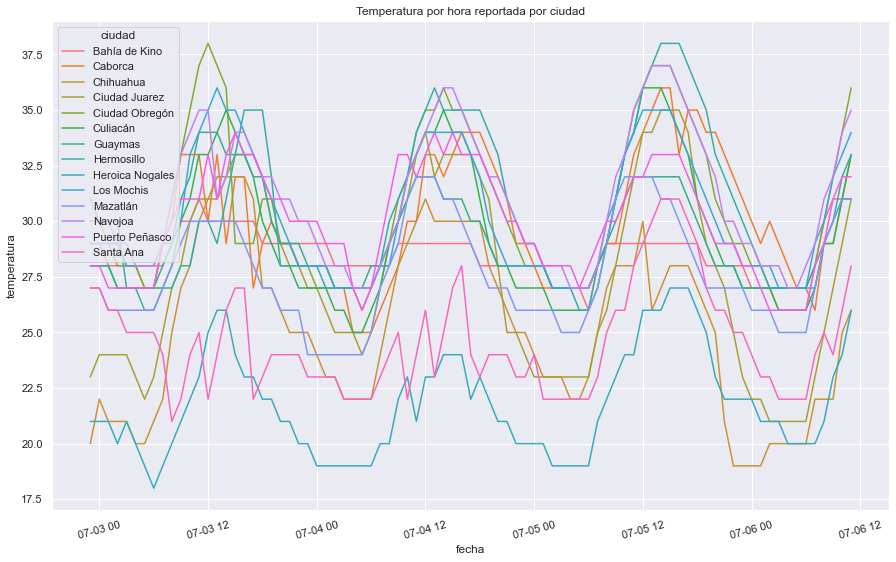

In [67]:
sns.set(rc={'figure.figsize':(15,9)})
sns.lineplot(x=df.fecha, y=df.temperatura, hue= df.ciudad)
plt.xticks(rotation=15)
plt.title('Temperatura por hora reportada por ciudad')
plt.show()

Una alternativa a este problema es utilizar los mapas de calor, como veremos a continuación estos permiten ver de manera mas clara el comportamiento de las variables y permite comparar entre ciudades de manera mas directa/sencilla.

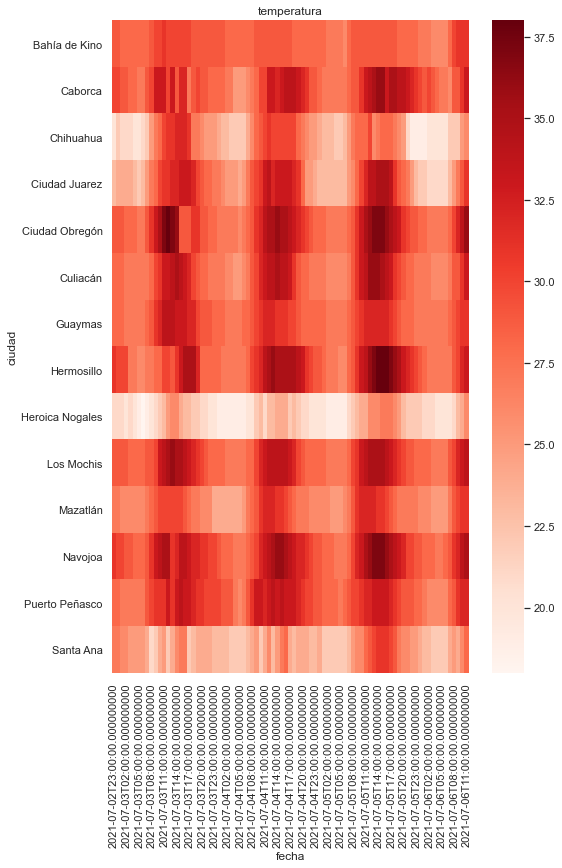

********************************************************************************


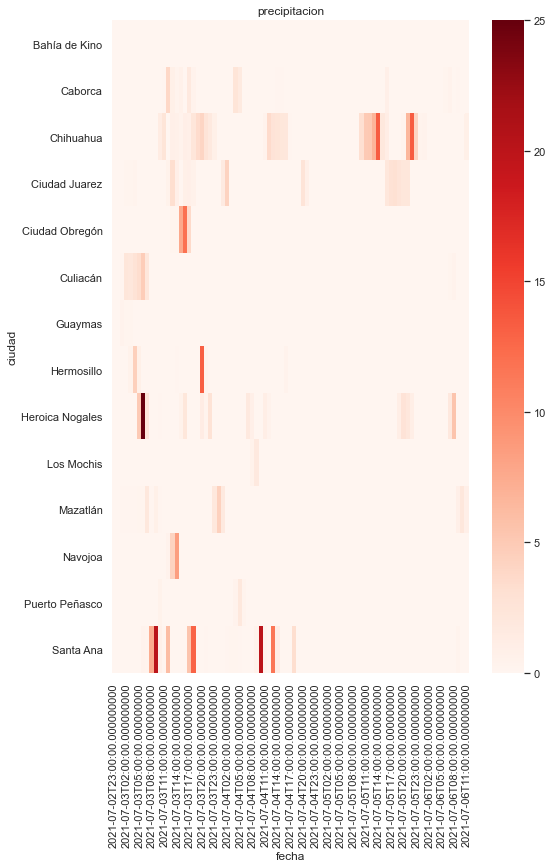

********************************************************************************


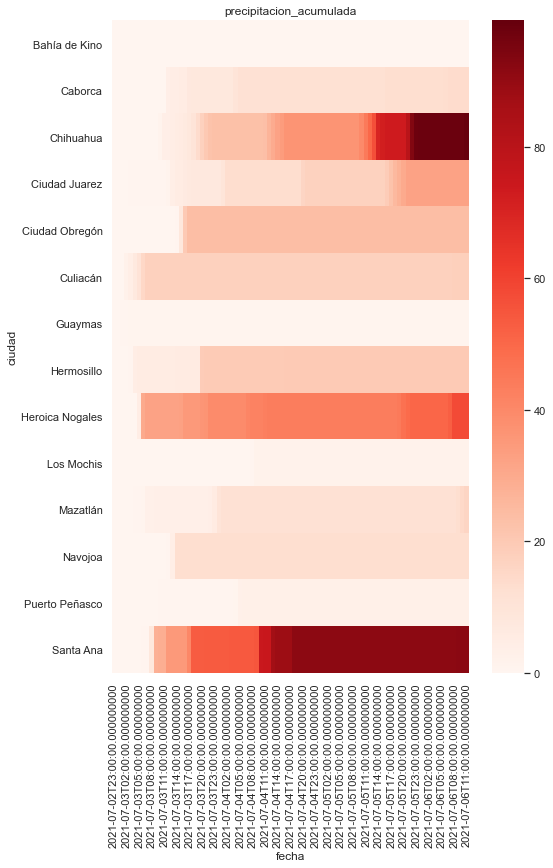

********************************************************************************


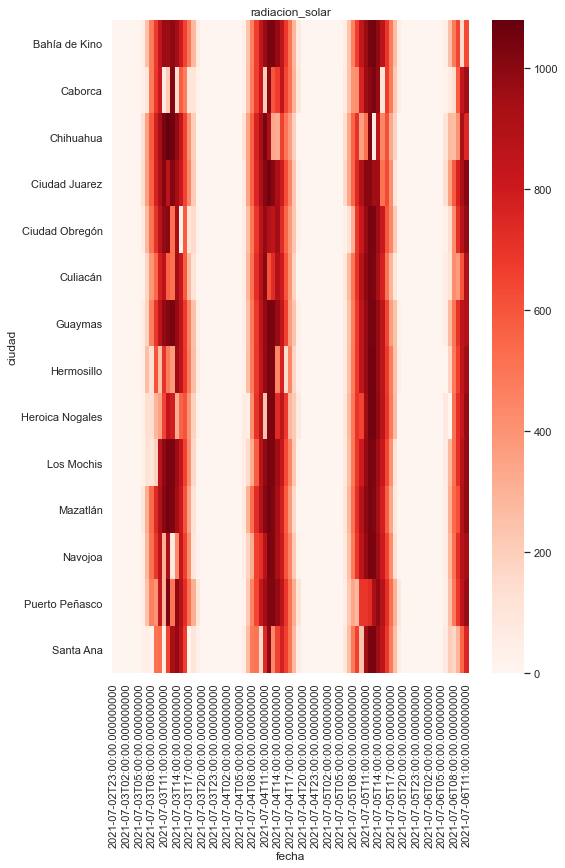

********************************************************************************


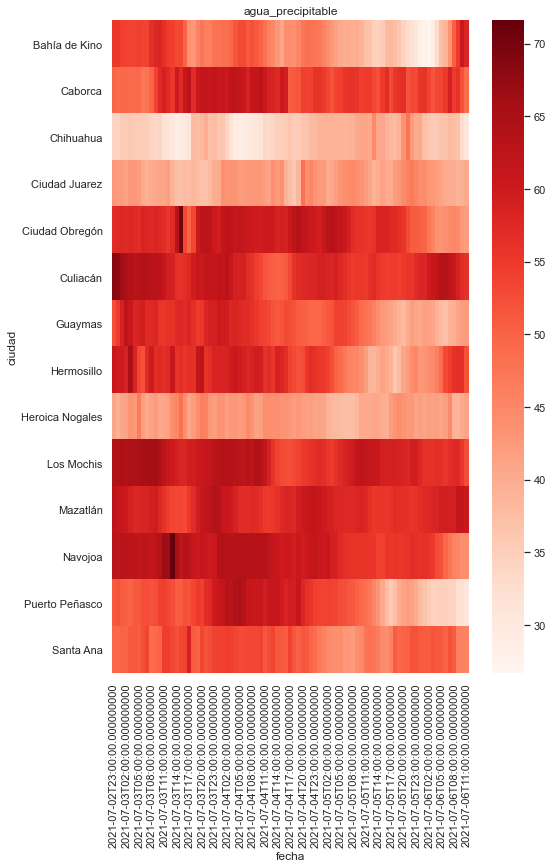

********************************************************************************


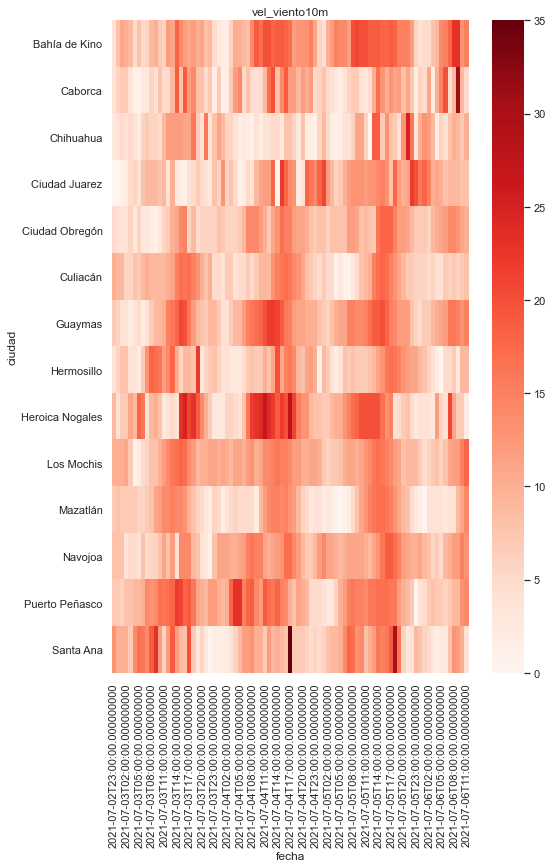

********************************************************************************


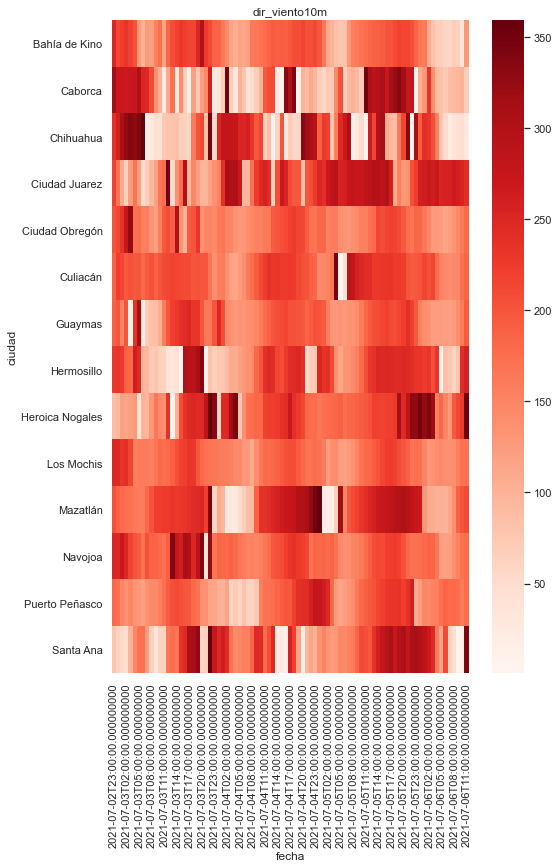

********************************************************************************


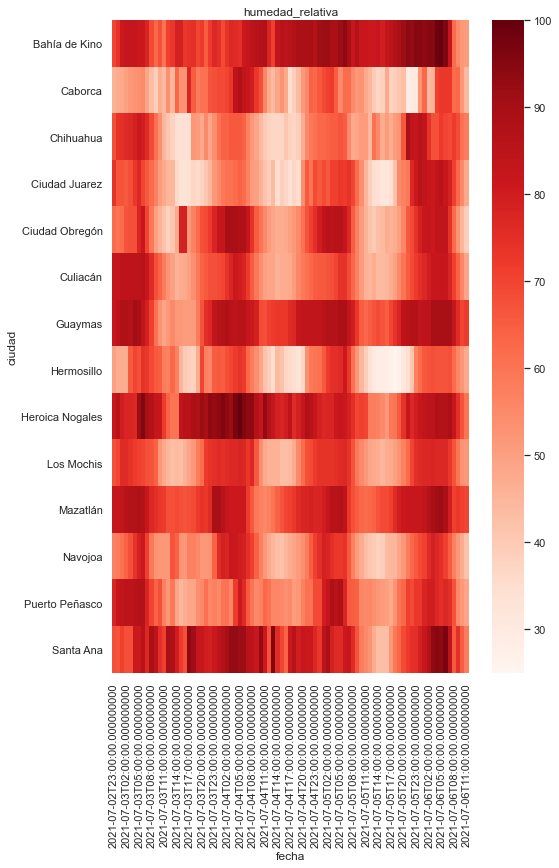

********************************************************************************


In [68]:
for column in df:
    if column in ['fecha', 'ciudad', 'dominio']:
       continue 
    else:
        #Analizando temperatura sobre el tiempo
        df3 = df[['fecha','ciudad', column]]
        # pandas pivot with multiple variables
        heatmap3_data = pd.pivot_table(df3,values=column, index='ciudad', columns='fecha')
        plt.figure(figsize=(8, 12))
        sns.set(rc={'figure.figsize':(15,9)})
        plt.title(column)
        sns.heatmap(heatmap3_data, cmap="Reds")
        plt.show()
        print('**'*40)

Además, analizaremos la distribución de las variables de todo el DataFrame con el fin de ver como está distribuida cada variable

array([[<AxesSubplot:title={'center':'fecha'}>,
        <AxesSubplot:title={'center':'temperatura'}>,
        <AxesSubplot:title={'center':'precipitacion'}>],
       [<AxesSubplot:title={'center':'precipitacion_acumulada'}>,
        <AxesSubplot:title={'center':'radiacion_solar'}>,
        <AxesSubplot:title={'center':'agua_precipitable'}>],
       [<AxesSubplot:title={'center':'vel_viento10m'}>,
        <AxesSubplot:title={'center':'dir_viento10m'}>,
        <AxesSubplot:title={'center':'humedad_relativa'}>]], dtype=object)

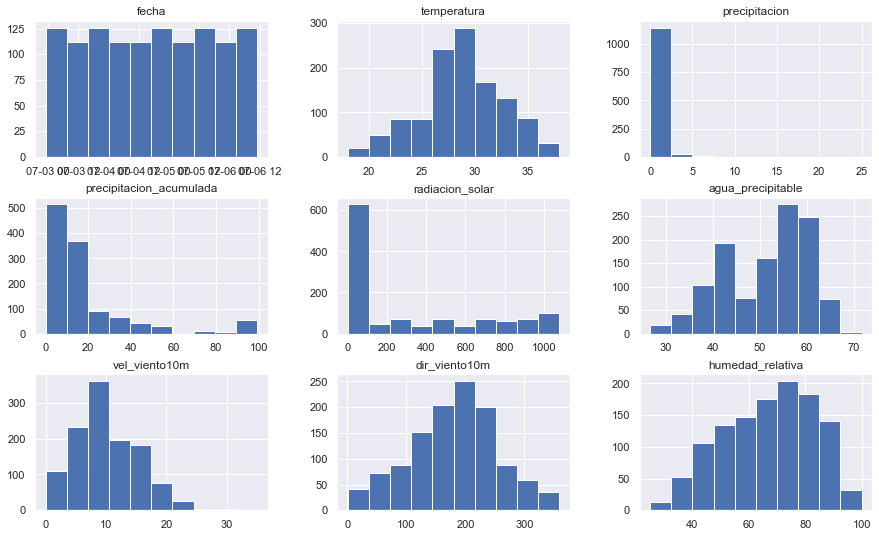

In [69]:
df.hist()

#### Distribuciones de algunas variables por ciudad

Text(0.5, 1.0, 'Distribución de la temperatura en las diferentes ciudades')

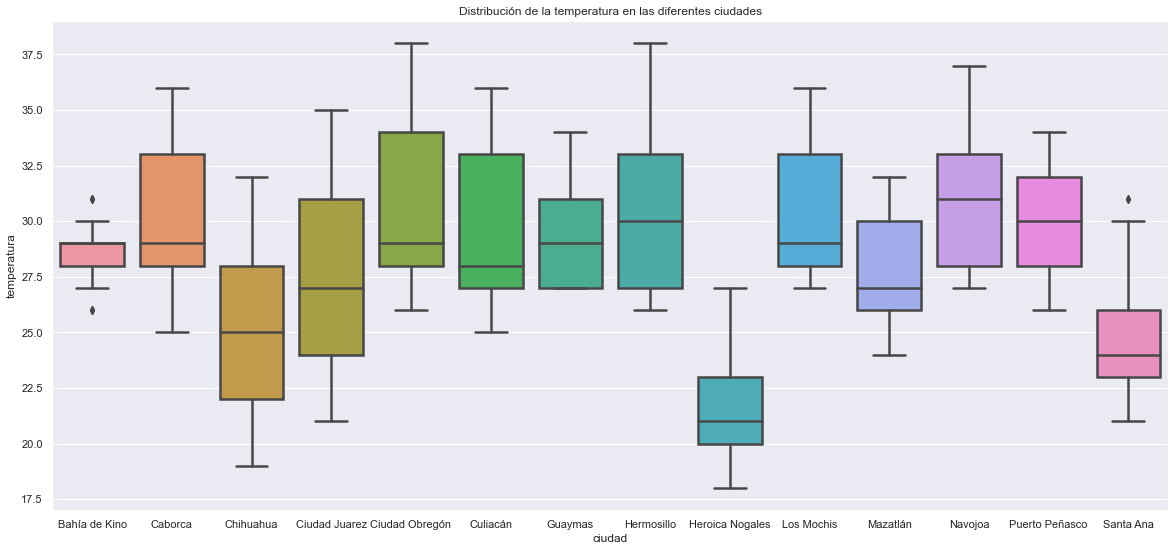

In [70]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x="ciudad", y="temperatura", data=df, linewidth=2.5)
ax.set_title('Distribución de la temperatura en las diferentes ciudades')

Text(0.5, 1.0, 'Distribución de la humedad en las diferentes ciudades')

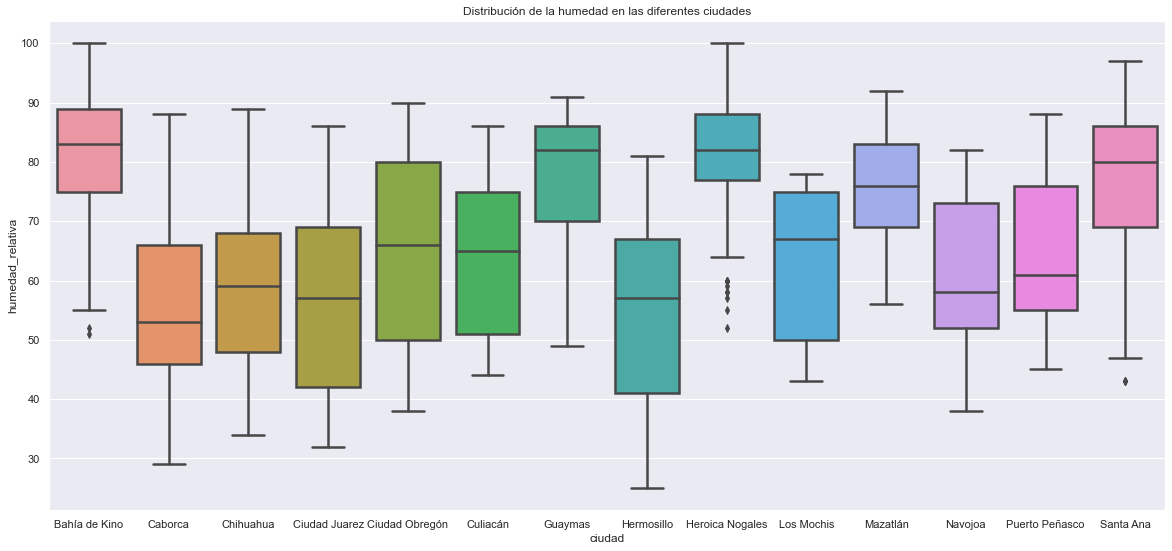

In [71]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x="ciudad", y="humedad_relativa", data=df, linewidth=2.5)
ax.set_title('Distribución de la humedad en las diferentes ciudades')

Text(0.5, 1.0, 'Distribución de la radiación solar en las diferentes ciudades')

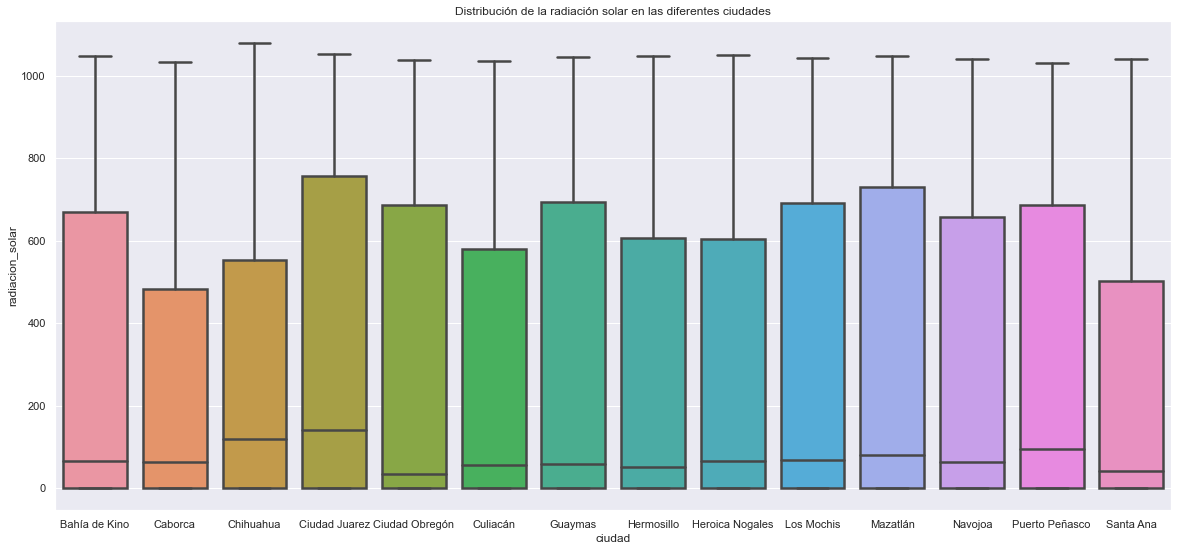

In [72]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x="ciudad", y="radiacion_solar", data=df, linewidth=2.5)
ax.set_title('Distribución de la radiación solar en las diferentes ciudades')

Text(0.5, 1.0, 'Distribución de la velocidad del viento en las diferentes ciudades')

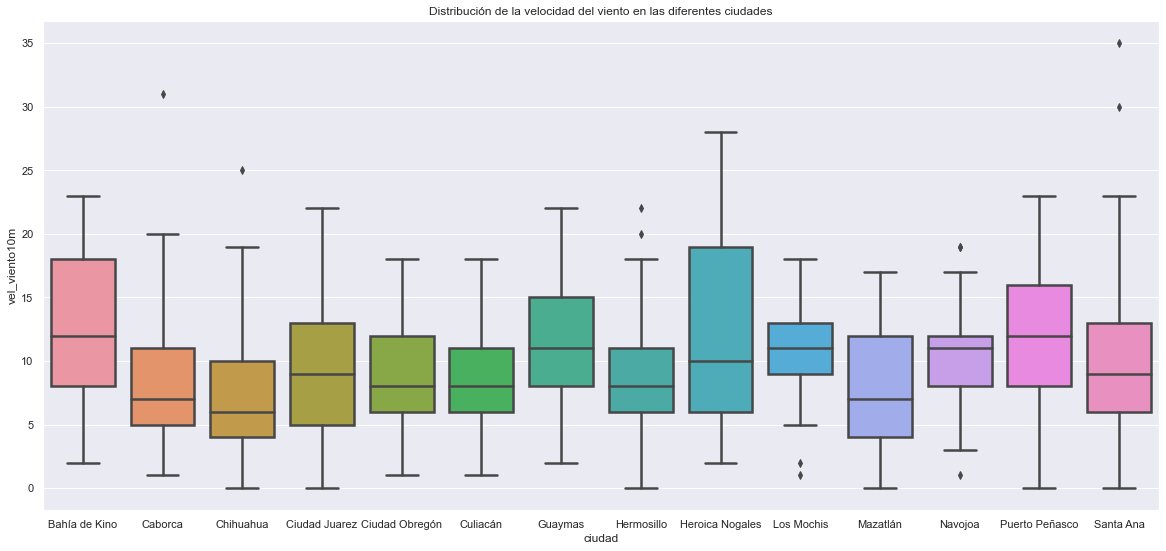

In [73]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x="ciudad", y="vel_viento10m", data=df, linewidth=2.5)
ax.set_title('Distribución de la velocidad del viento en las diferentes ciudades')

#### Distribuciones de algunas variables por hora

Text(0.5, 1.0, 'Distribución de la temperatura por hora')

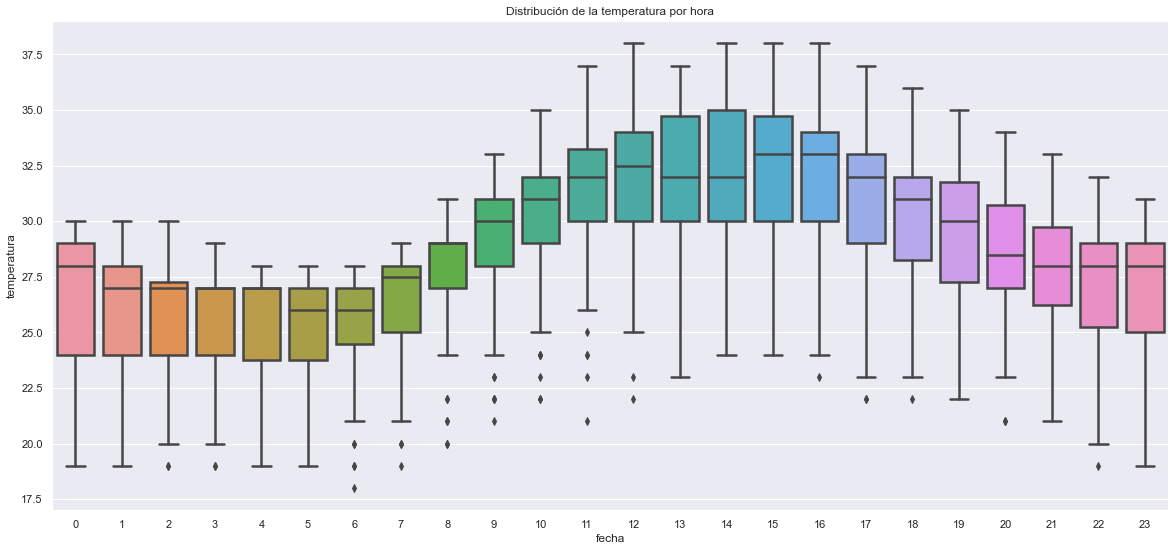

In [74]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x=df.fecha.dt.hour, y=df.temperatura, data=df, linewidth=2.5)
ax.set_title('Distribución de la temperatura por hora')

Text(0.5, 1.0, 'Distribución de la humedad relativa por hora')

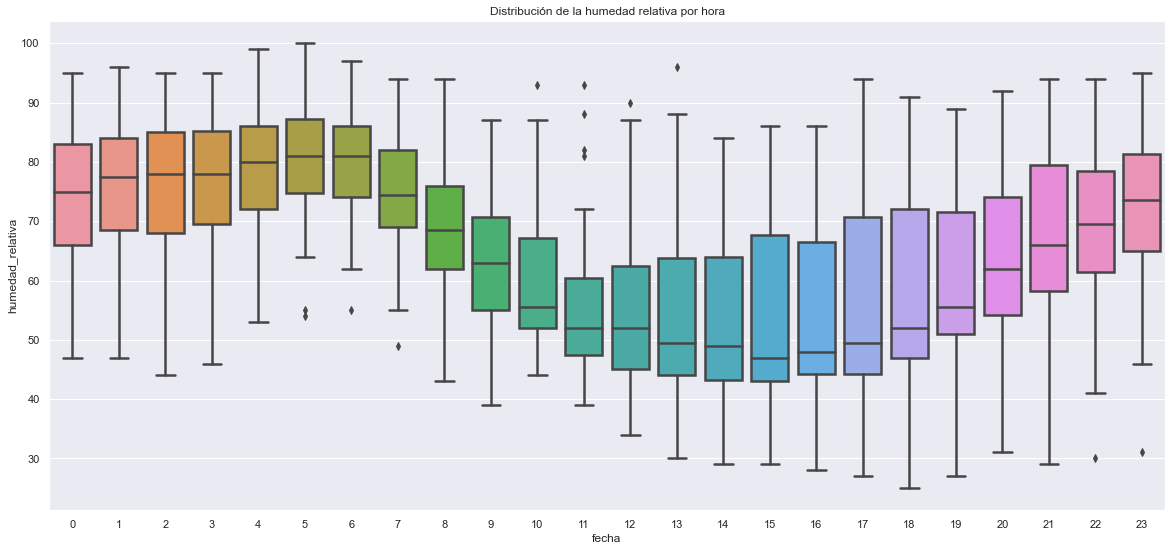

In [75]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x=df.fecha.dt.hour, y=df.humedad_relativa, data=df, linewidth=2.5)
ax.set_title('Distribución de la humedad relativa por hora')

Text(0.5, 1.0, 'Distribución de la velocidad del viento por hora')

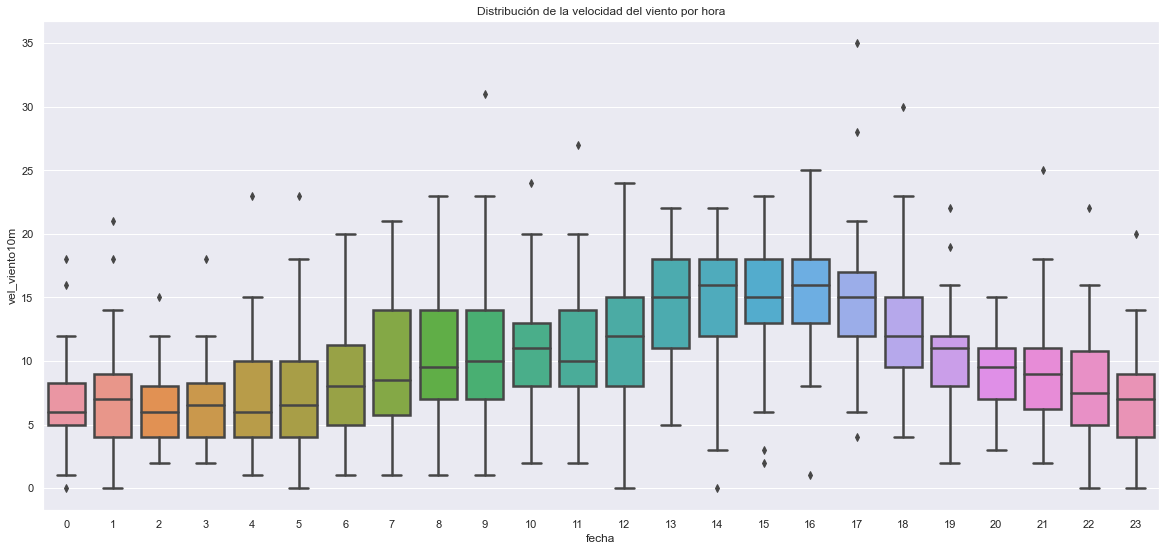

In [76]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x=df.fecha.dt.hour, y=df.vel_viento10m, data=df, linewidth=2.5)
ax.set_title('Distribución de la velocidad del viento por hora')

Text(0.5, 1.0, 'Distribución de la radiacion solar por hora')

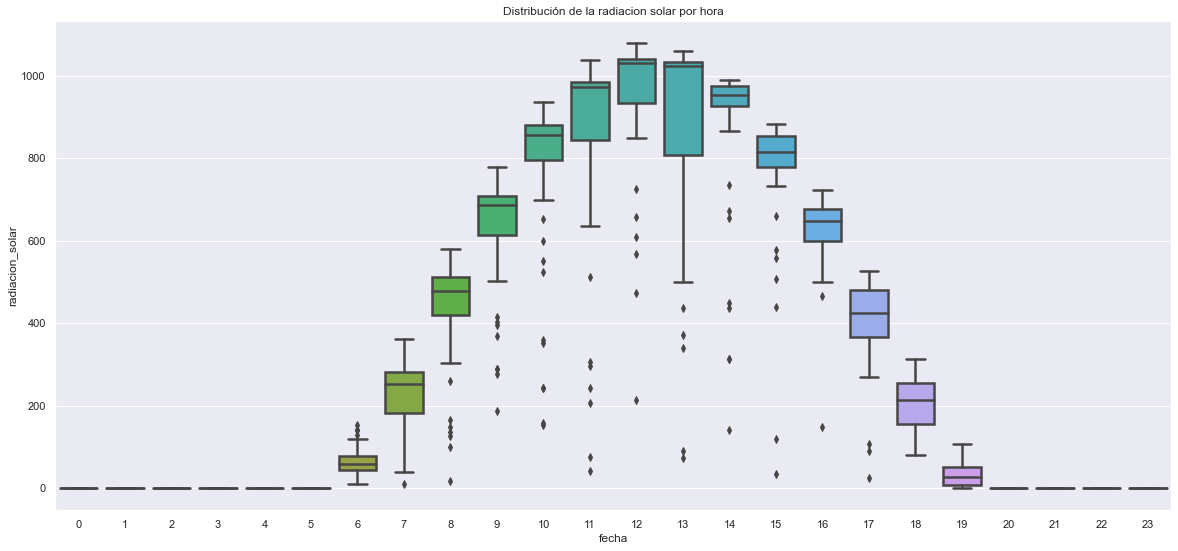

In [77]:
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x=df.fecha.dt.hour, y=df.radiacion_solar, data=df, linewidth=2.5)
ax.set_title('Distribución de la radiacion solar por hora')

Por ultimo, analizaremos las correlaciones para ver como se relacionan las variables unas con otras.

<AxesSubplot:>

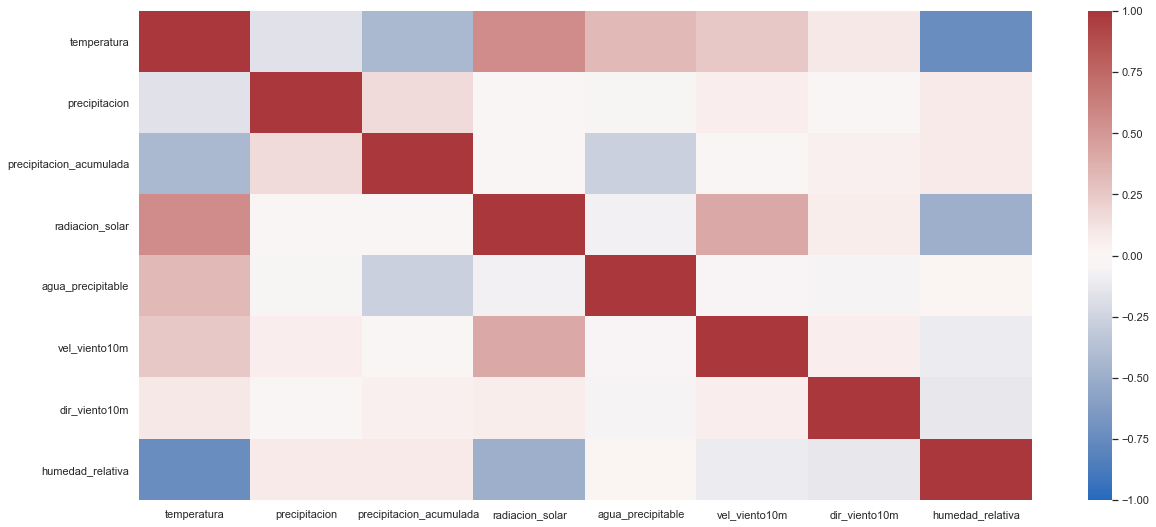

In [78]:
#Calculamos la matriz de correlacion 
corr = df.corr()
# Graficamos el heatmap
sns.heatmap(corr, cmap="vlag", vmin=-1, vmax=1)

### **Conclusión EDA**

Se logró realizar el análisis de datos exploratorio. El Dataset no presentaba datos perdidos ni duplicados lo cual será una ventaja a la hora de hacer el modelado. A la hora de explorar los datos se encontró como se distribuían cada una de las variables registradas para cada ciudad, tal como que Chihuahua, Santa Ana y Nogales presentaron mayor precipitación acumulada en estas fechas. Támbien que Nogales presentó una temperatura promedio considerablemente mas baja a comparación de las otras ciudades. Por otro lado, analizando la distribución de las variables por hora nos permitió conocer como se comportan las variables en el transcurso del día, por ejemplo que la humedad relativa aumenta en la madrugada y disminuye por la tarde. Por ultimo, analizando las correlaciones vemos que la radiación solar y la temperatura están positivamente correlacionados (como es de esperarse), tambien la radiación solar y la velocidad del viento están ligeramente correlacionados y la temperatura y la humedad relativa están negativamente correlacionados. 

### **Detección de anomalías**

#### Z- Score

El Z-Score para un dato nos dice cuantas desviaciones estandar se encuentra alejado de la media, esto nos permitirá detectar que datos son anomalías. La regla general es usar 2, 2.5, 3 o 3.5 como threshold de Z-Score.
Lo que se hace en el codigo es lo siguiente:


*  Primero obtenemos las columnas numéricas 
*  Calculamos el Z-score para cada valor de la columna, relativo a la media de la columna y su desviación estandar
*  Toma el valor absoluto de el Z-score porque no importa si es positivo o negativo, con que no pase el threshold
*  La parte de all(axis=1) asegura que en cada fila, ningun elemento pase del threshold.
*  Por ultimo esa boolean mask se le pone al Dataframe para filtrar.




In [79]:
from scipy import stats
#Filtramos solo datos numericos
df_numerics_only = df.select_dtypes(include=np.number)
#Poniendo threshold 3
df_filtered_3 = df[(np.abs(stats.zscore(df_numerics_only)) < 3).all(axis=1)]
#Poniendo threshold 2.5
df_filtered_25 = df[(np.abs(stats.zscore(df_numerics_only)) < 2.5).all(axis=1)]
#Poniendo threshold 2
df_filtered_2 = df[(np.abs(stats.zscore(df_numerics_only)) < 2).all(axis=1)]

Ahora veremos que tantos datos se filtraron con cada uno de los thresholds

In [80]:
print("Dataset original: " + str(df.shape[0]) )
print("Threshold 3: " + str(df_filtered_3.shape[0]))
print("Threshold 2.5: " + str(df_filtered_25.shape[0]))
print("Threshold 2: " + str(df_filtered_2.shape[0]))

Dataset original: 1190
Threshold 3: 1111
Threshold 2.5: 1096
Threshold 2: 930


#### Envolvente Elíptica 

Este metodo de deteccion de anomalias crea un area eliptica dentro de la cual se encuentras los valores tipicos, lo que permite identificar anomalias.

In [81]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [82]:
df2 = df[['temperatura', 'precipitacion', 'precipitacion_acumulada', 'radiacion_solar', 'agua_precipitable', 'vel_viento10m', 'dir_viento10m','humedad_relativa']].to_numpy()
df2.shape

(1190, 8)

Se establecen 2 matrices de covarianza la del estimador robusto (MCD) y del estimador empirico (MLE), y se creauna matriz de covarianzas estimadas.

In [83]:
robust_cov = MinCovDet().fit(df2)
estimado_MCD = robust_cov.mahalanobis(df2)

In [84]:
robust_cov = MinCovDet().fit(df2)
estimado_MCD = robust_cov.mahalanobis(df2)

emp_cov = EmpiricalCovariance().fit(df2)
estimado_MLE = emp_cov.mahalanobis(df2)

print('Matrices de covarianza estimadas:\n' +
      f'MCD:\n{robust_cov.covariance_}\n' +
      f'MLE:\n{emp_cov.covariance_}')

Matrices de covarianza estimadas:
MCD:
[[ 8.28968858e+00 -1.67883737e-01  2.63160277e+00  7.80691696e+02
  -6.14654671e-01  6.57778547e+00  7.55831834e+01 -3.62560415e+01]
 [-1.67883737e-01  7.60620125e-01  6.36606339e-01 -1.62883114e+01
   6.52015391e-01 -2.28788927e-01  1.34121938e+00  7.88490796e-01]
 [ 2.63160277e+00  6.36606339e-01  6.85360570e+01  1.81460346e+01
   6.22230898e+00 -5.40430450e+00  1.24258436e+01 -3.13366239e+01]
 [ 7.80691696e+02 -1.62883114e+01  1.81460346e+01  1.41963346e+05
  -3.38725419e+02  8.92311142e+02  4.40057862e+03 -2.90655758e+03]
 [-6.14654671e-01  6.52015391e-01  6.22230898e+00 -3.38725419e+02
   4.92047870e+01 -7.05363322e+00 -2.78511170e+01  1.06765232e+00]
 [ 6.57778547e+00 -2.28788927e-01 -5.40430450e+00  8.92311142e+02
  -7.05363322e+00  2.19800692e+01  4.72815917e+01 -1.85966090e+01]
 [ 7.55831834e+01  1.34121938e+00  1.24258436e+01  4.40057862e+03
  -2.78511170e+01  4.72815917e+01  4.21868720e+03 -3.13405066e+02]
 [-3.62560415e+01  7.88490796e

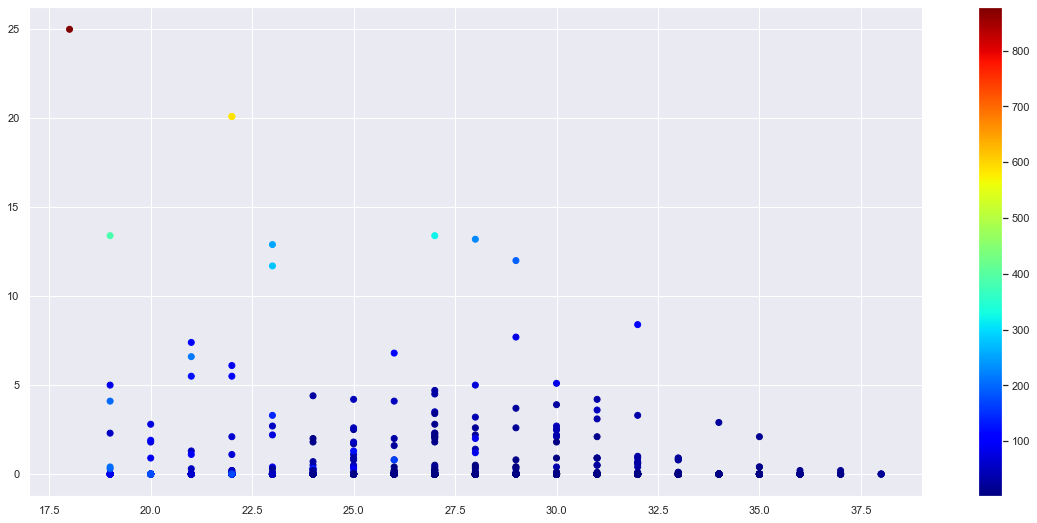

In [85]:
plt.scatter(x=df2[:,0], y=df2[:,1], c=estimado_MCD, cmap='jet')
plt.colorbar()
plt.show()

Para acotar los parametros de deteccion se modifica el umbral de seleccion de outliers 

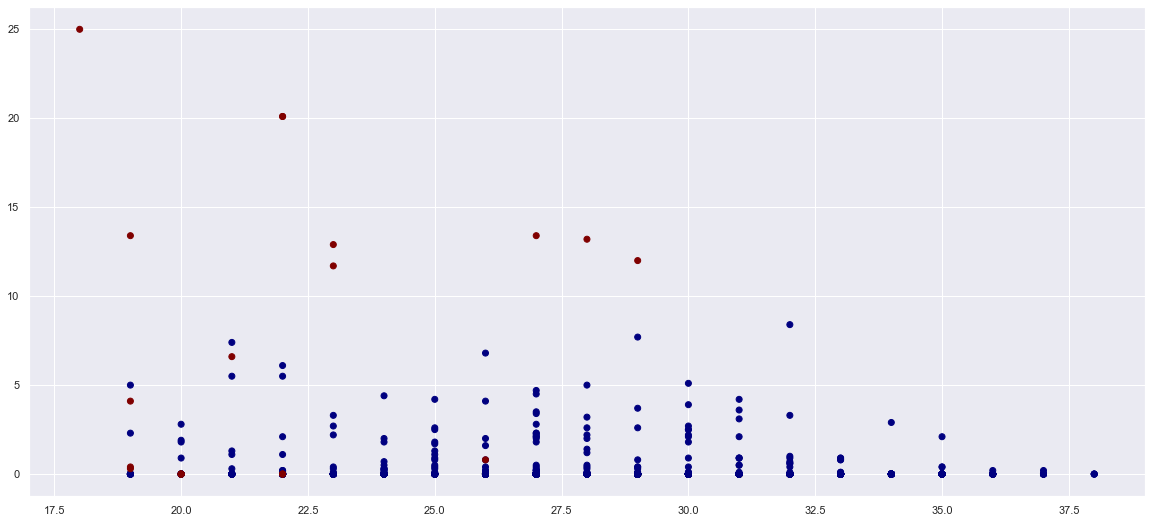

In [86]:
plt.scatter(x=df2[:,0], y=df2[:,1], c=np.where(estimado_MCD < 150, 0, 10), cmap='jet')
plt.show()

#### Isolation Forest

Este metodo lo que hace es dividir los datos repetidamente hasta lograr aislarlos y selecciona los que tomaron menos pasos para ailarlos, estos los clasifica como outliers, ya que son los menos relacionados con el resto de los datos.

In [87]:
from sklearn.ensemble import IsolationForest

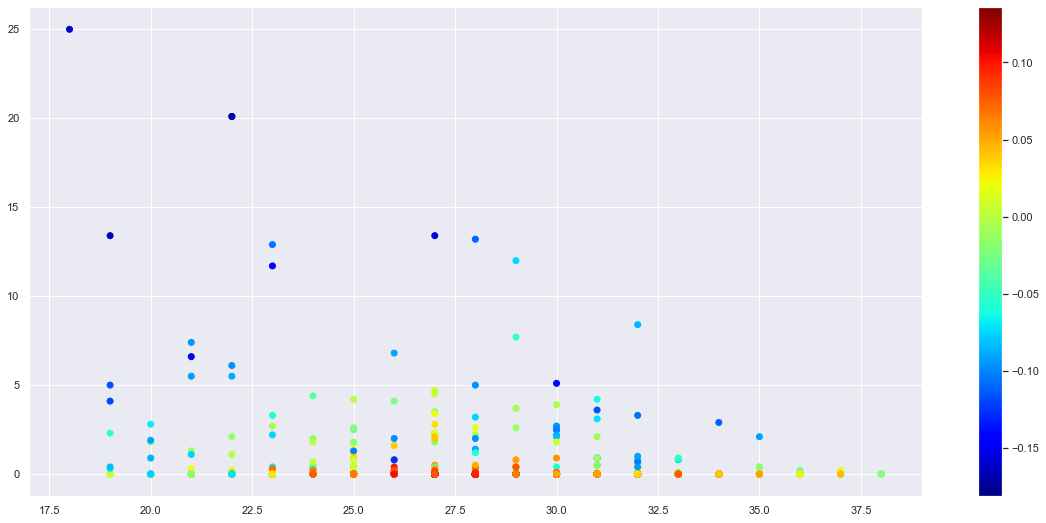

In [88]:
clf = IsolationForest(n_estimators=50, warm_start=True)
clf.fit(df2)

estimado_IF = clf.decision_function(df2)

plt.scatter(x=df2[:,0], y=df2[:,1], c=estimado_IF, cmap='jet')
plt.colorbar()
plt.show()

De igual forma como se hizo en el caso de la envolvente eliptica, se pueden ajustar los paramentros para acotar los outliers

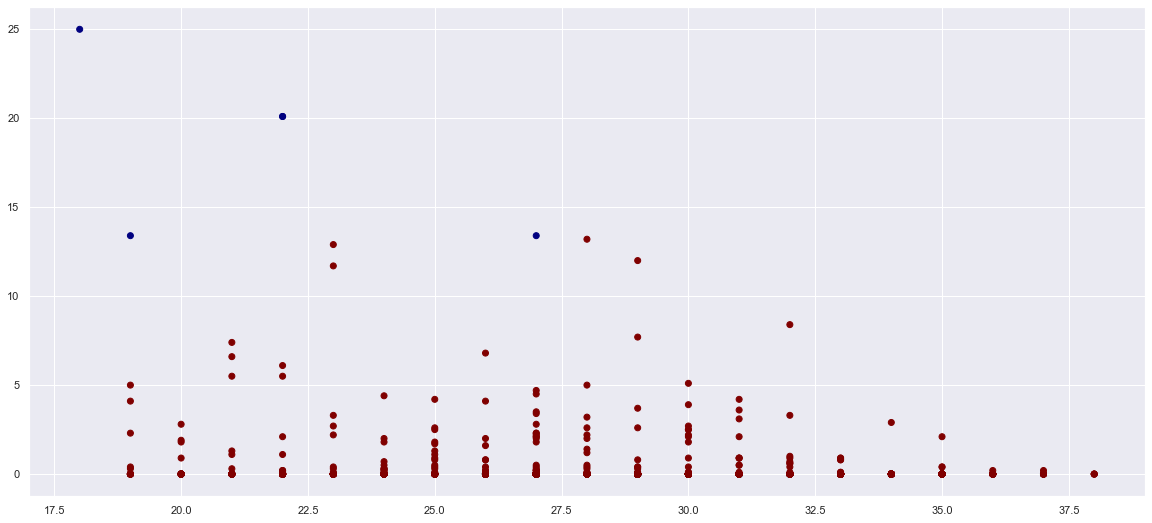

In [89]:
plt.scatter(x=df2[:,0], y=df2[:,1], c=np.where(estimado_IF > -0.15, 1, 0), cmap='jet')
plt.show()

#### Local Outlier Factor

Este es un método no supervisado para la detección de anomalias calculando la desviacion de densidad local de un punto de datos con respecto a sus vecinos.

Creación del Modelo

In [90]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=20)


Predicción

In [91]:
lof = model.fit_predict(df2)

Graficar los outliers detectados

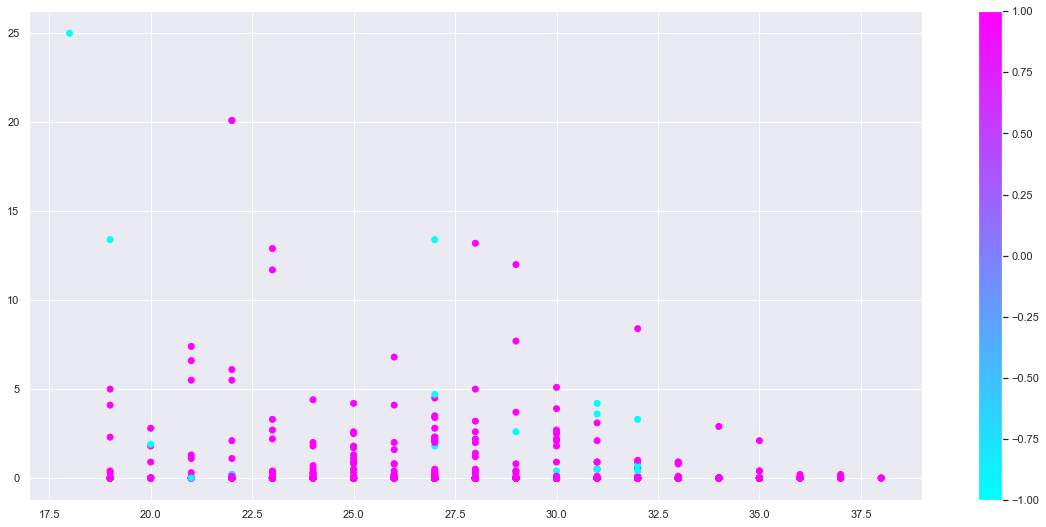

In [92]:
plt.scatter(df2[:, 0], df2[:, 1], c=lof, cmap="cool")
plt.colorbar()
plt.show()

Como podemos ver, detecta algunos valores que no deberian ser outliers.
Podemos utilizar algunos de los distintos parametros para encontrar un mejor resultado.




*   n_neighbors = default es 20
*   algorithm = ball_tree, kd_tree, brute y auto. default es auto
*   metric = De scikit-learn tenemos cityblock, cosine, euclidean, manhattan 
*   contamination = proporción de datos contaminados del dataset, el rango debe estar entre 0 y 0.5

Procedemos a jugar con algunos de estos valores

In [93]:
def LOF(df, neighbors, algorithm, metric, contamination):
    model = LocalOutlierFactor(n_neighbors=neighbors, algorithm=algorithm, metric=metric, contamination=contamination)
    lof = model.fit_predict(df)
    
    plt.scatter(df[:, 0], df[:, 1], c=lof, cmap='cool')
    plt.colorbar()
    plt.title(["Neighbors: {}".format(neighbors), "Algorithm: {}".format(algorithm), "Metric: {}".format(metric), "Contamination: {}".format(contamination)])
    plt.show()


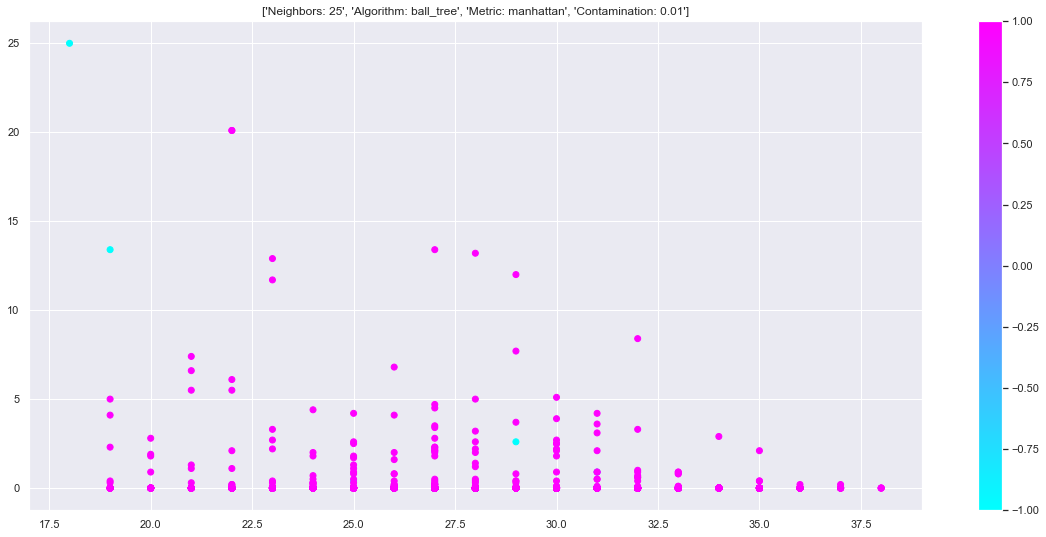

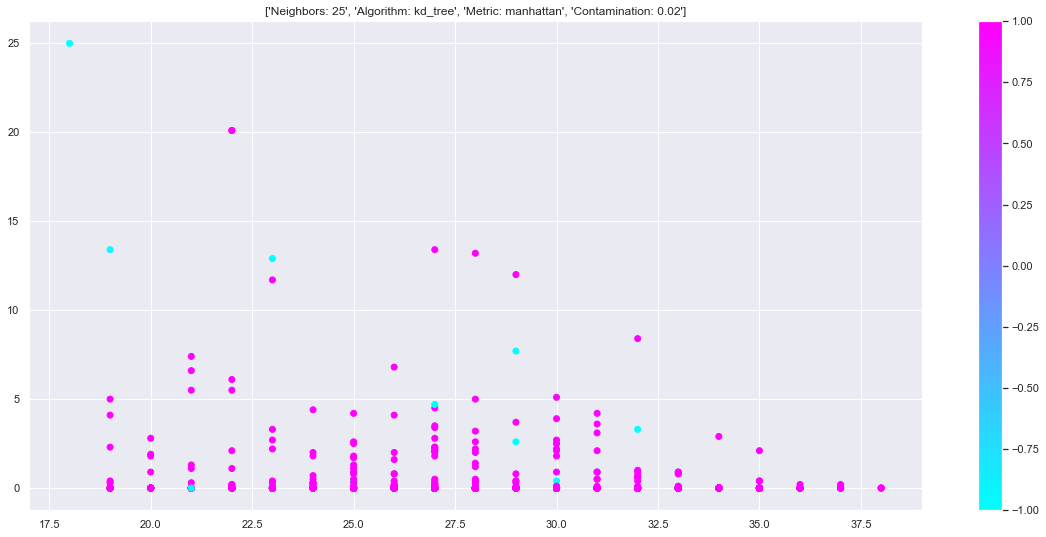

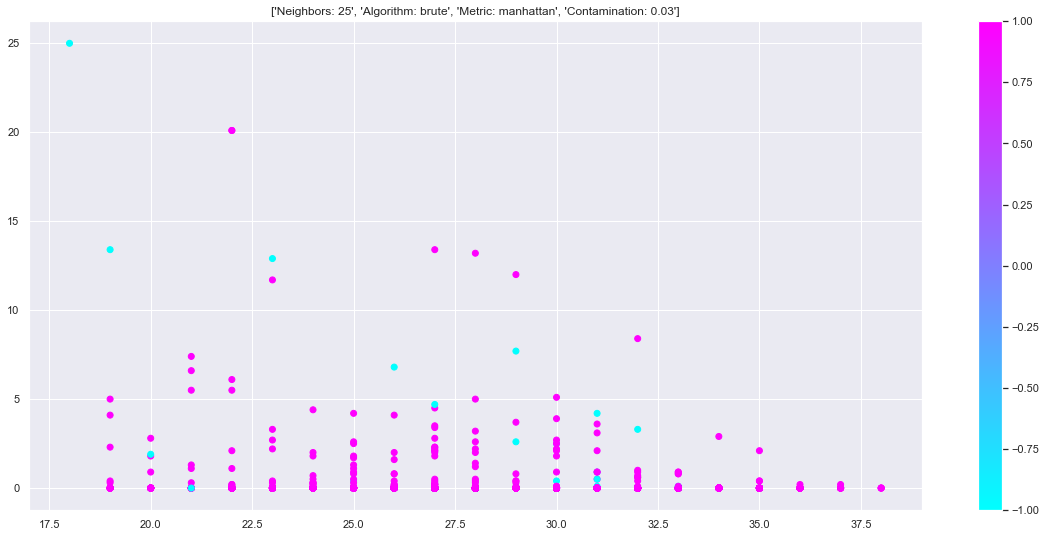

In [94]:
LOF(df2, 25, "ball_tree", "manhattan", 0.01)
LOF(df2, 25, "kd_tree", "manhattan", 0.02)
LOF(df2, 25, "brute", "manhattan", 0.03)

De estos tres casos el que mejor resultado dio fue la combinación de los siguientes parámetros.



*   n_neighbors: 25 
*   algorithm: ball_tree
*   metric: manhattan
*   contamination: 0.01



Análisis de anomalías detectadas con Local Outlier Factor

Como podemos ver, la precipitación fue un factor muy importante que influyo en la detección de anomalías. 
Esto debido a que las condiciones climatologicas para cada ciudad pueden llegar a ser bastante diferentes.

In [95]:
model = LocalOutlierFactor(n_neighbors=25, algorithm="ball_tree", metric="manhattan", contamination=0.01)
lof = model.fit_predict(df2)

#Imprimir solo los outliers detectados
outliers = []
for index in range(len(lof)):
  if lof[index] < 0 :
    outliers.append(index)

df.iloc[outliers].sort_values(by=["fecha"])

,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
177,2021-07-03 06:00:00,Heroica Nogales,18,25.0,30.0,27,41.8,16,99,96
347,2021-07-03 06:00:00,Santa Ana,25,0.4,0.4,26,52.6,16,174,86
1027,2021-07-03 06:00:00,Los Mochis,28,0.0,0.0,34,65.3,5,161,70
863,2021-07-03 12:00:00,Chihuahua,31,0.0,3.9,1079,31.0,12,78,41
864,2021-07-03 13:00:00,Chihuahua,31,0.9,4.9,1060,30.3,12,80,38
554,2021-07-04 19:00:00,Bahía de Kino,28,0.0,0.0,74,45.2,13,209,89
809,2021-07-04 19:00:00,Ciudad Juarez,31,0.0,13.5,30,38.8,2,199,35
578,2021-07-05 19:00:00,Bahía de Kino,28,0.0,0.0,53,36.4,15,218,89
833,2021-07-05 19:00:00,Ciudad Juarez,29,2.6,27.8,13,43.0,12,153,55
921,2021-07-05 22:00:00,Chihuahua,19,13.4,93.6,0,42.2,16,4,84


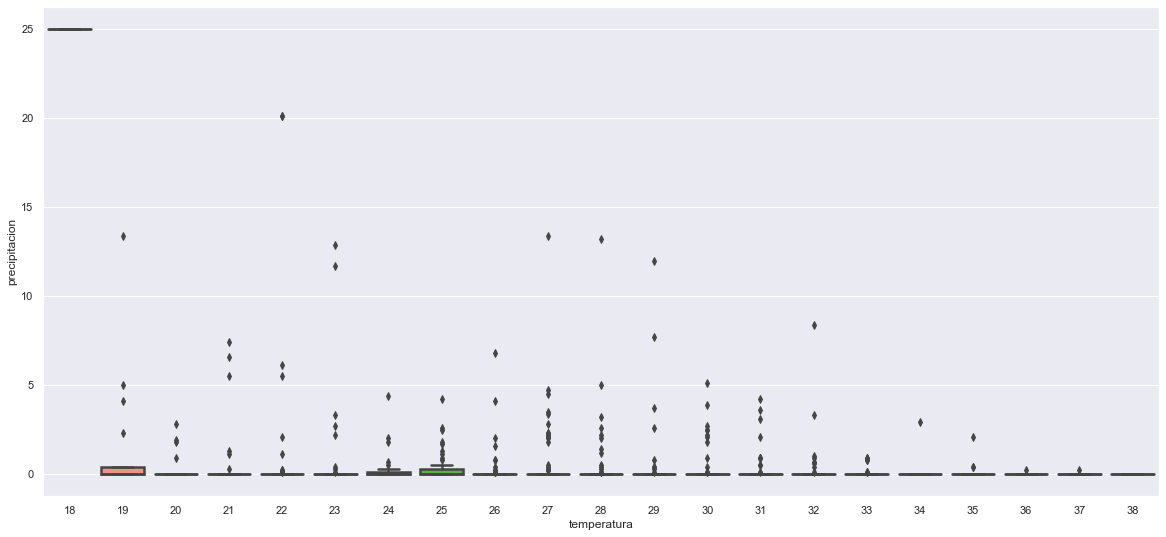

In [96]:
#Boxplot para buscar datos anomalos
sns.set(rc={'figure.figsize':(20,9)})
ax = sns.boxplot(x=df["temperatura"], y=df["precipitacion"], data=df, linewidth=2.5)

Text(0.5, 1.0, 'Temperatura detectada como anomala')

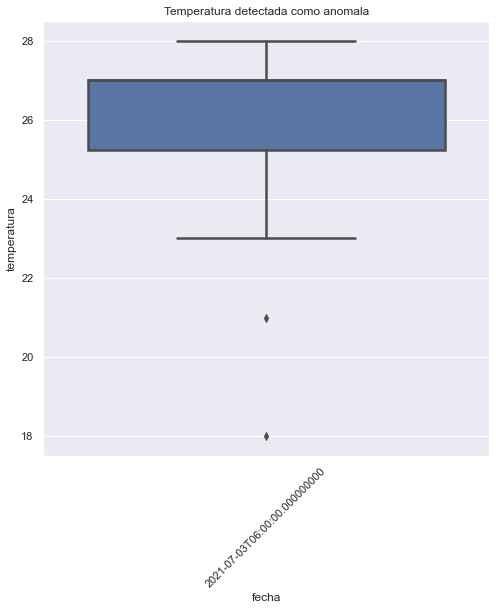

In [97]:
#Boxplost para revisar la anomalía en un tiempo en particular
sns.set(rc={'figure.figsize':(8,8)})

df_fecha = df[df["fecha"] == "2021-07-03 06:00:00"]

ax = sns.boxplot(x=df_fecha["fecha"], y=df_fecha["temperatura"], data=df_fecha, linewidth=2.5)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_title('Temperatura detectada como anomala')

Observación: Al estar la temperatura muy por debajo de la media la detecta como outlier

Text(0.5, 1.0, 'Precipitación detectada como anomala muy por encima de la media ')

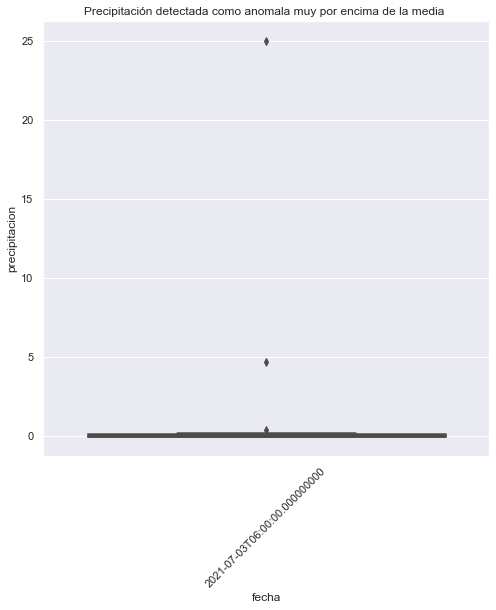

In [101]:
ax = sns.boxplot(x=df_fecha["fecha"], y=df_fecha["precipitacion"], data=df_fecha, linewidth=2.5)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_title('Precipitación detectada como anomala muy por encima de la media ')

Observación: Una precipitación de 25mm dista mucho de la media de casi 0

### Viendo anomalías detectadas

Ahora analizaremos los registro detectados como anomalías para ver que fue lo detectado

In [99]:
df_anomaly = df[(np.abs(stats.zscore(df_numerics_only)) > 3)]
df_anomaly.head()

,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
21,2021-07-03 20:00:00,Hermosillo,28,13.2,19.1,0,62.5,3,339,70
101,2021-07-03 15:00:00,Ciudad Obregón,29,7.7,8.1,35,70.2,14,135,79
102,2021-07-03 16:00:00,Ciudad Obregón,29,12.0,20.1,583,53.3,15,98,79
177,2021-07-03 06:00:00,Heroica Nogales,18,25.0,30.0,27,41.8,16,99,96
206,2021-07-04 11:00:00,Heroica Nogales,21,1.1,43.3,242,44.2,27,220,93


In [100]:
from IPython.display import display
for ciudad in df_anomaly.ciudad.unique():
  print('Anomalias detectadas en ' + ciudad + ' [Z-Score con Threshold de 2]')
  display(df_anomaly[df_anomaly['ciudad'] == ciudad].head())
  print('***' * 30)

Anomalias detectadas en Hermosillo [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
21,2021-07-03 20:00:00,Hermosillo,28,13.2,19.1,0,62.5,3,339,70


******************************************************************************************
Anomalias detectadas en Ciudad Obregón [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
101,2021-07-03 15:00:00,Ciudad Obregón,29,7.7,8.1,35,70.2,14,135,79
102,2021-07-03 16:00:00,Ciudad Obregón,29,12.0,20.1,583,53.3,15,98,79


******************************************************************************************
Anomalias detectadas en Heroica Nogales [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
177,2021-07-03 06:00:00,Heroica Nogales,18,25.0,30.0,27,41.8,16,99,96
206,2021-07-04 11:00:00,Heroica Nogales,21,1.1,43.3,242,44.2,27,220,93
212,2021-07-04 17:00:00,Heroica Nogales,22,0.0,43.7,289,42.8,28,272,85
251,2021-07-06 08:00:00,Heroica Nogales,21,5.5,58.0,515,39.3,11,196,83


******************************************************************************************
Anomalias detectadas en Caborca [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
337,2021-07-06 09:00:00,Caborca,29,0.1,13.9,581,56.1,31,96,63


******************************************************************************************
Anomalias detectadas en Santa Ana [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
349,2021-07-03 08:00:00,Santa Ana,21,7.4,8.1,18,48.7,19,64,89
350,2021-07-03 09:00:00,Santa Ana,22,20.1,28.1,516,49.3,23,33,85
353,2021-07-03 12:00:00,Santa Ana,22,6.1,35.0,657,54.7,12,167,90
358,2021-07-03 17:00:00,Santa Ana,22,5.5,40.6,24,58.9,20,308,94
359,2021-07-03 18:00:00,Santa Ana,23,12.9,53.4,104,50.8,7,313,91


******************************************************************************************
Anomalias detectadas en Navojoa [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
440,2021-07-03 14:00:00,Navojoa,32,8.4,13.0,437,65.2,4,275,64


******************************************************************************************
Anomalias detectadas en Chihuahua [Z-Score con Threshold de 2]


,fecha,ciudad,temperatura,precipitacion,precipitacion_acumulada,radiacion_solar,agua_precipitable,vel_viento10m,dir_viento10m,humedad_relativa
912,2021-07-05 13:00:00,Chihuahua,26,6.8,56.7,72,44.8,19,216,61
913,2021-07-05 14:00:00,Chihuahua,27,13.4,70.1,866,40.7,19,298,55
920,2021-07-05 21:00:00,Chihuahua,21,6.6,80.2,0,47.6,25,336,89
921,2021-07-05 22:00:00,Chihuahua,19,13.4,93.6,0,42.2,16,4,84
921,2021-07-05 22:00:00,Chihuahua,19,13.4,93.6,0,42.2,16,4,84


******************************************************************************************


Como podermos ver, en terminos generales las anomalías detectadas son, por ejemplo en el caso de Hermosillo hubo precipitación/precipitación acumulada, o una alta radiación solar en conjunto con precipitación acumulada (como en el registro 913 de Chihuahua). Sin embargo, estos outliers se calcularon para todos los datos de las ciudades en un mismo Dataframe y como discutimos en clase unas condiciones climatológicas catalogadas como outliers para una ciudad pueden ser condiciones normales para otras (por ejemplo Hermosillo y Nogales). Por lo que hay ciertas mejoras que se pueden hacer para una mejor detección de outliers:     


*   Hacer la detección de outliers para los datos agrupados por ciudad.
*   Conseguir una mayor cantidad de datos para cada ciudad.

Esto permitiría definir con mayor exactitud que es un outlier para cada ciudad.



### Resultados y Conclusiones

La detección de outliers es uno de los pasos de preprocesamiento más importantes en el análisis de datos y, para obtener el mejor rendimiento, se considera un paso vital para los algoritmos de aprendizaje automático. En este proyecto se lograron aplicar diferentes métodos de detección de outliers al conjunto de datos de PROMETEUS. Como se puede ver en los resultados y gráficas anteriores, el número de outliers varía dependiendo del método utilizado, de los parámetros y del threshold(por ejemplo 3 en el Z-score o 150 en envolventes elípticas). Es por esto que además de saber aplicar los algoritmos es importante conocer de donde vienen los datos, como fueron recolectados para tener bien clara la idea del threshold que queremos definir.